# Final Project Morrison

Link to the Kaggle Dataset:
https://www.kaggle.com/datasets/emreksz/software-engineer-jobs-and-salaries-2024


# Problem Description

It is a common occurrence for job seekers to find jobs on job listing sites such as Indeed, Linkedin, etc. to look for their future employer. An issue with some of these job postings is that the salary expectation is not given in the posting, leaving job seekers blind to what the employer is expecting to pay for the job. This can be an issue for candidates who land interviews, just to find out that their and the employers salary expectations were vastly different, effectively wasting the time of both the candidate and employer.

Using the salary data from the kaggle dataset, I will engineer features and use them to predict SW engineering salaries to help combat this problem. In this project, I continue the work that I performed on this issue in the second ML course. Previously I used supervised algorithms to predict the salary based on the features I created from the data while using PCA as an unsupervised feature reduction technique. In this iteration of the project, I will utilize deep learning via a multilayer perceptron network to learn how to map the feature space into a predicted salary amount.

Using the MLP, I hope to further reduce the MAE from the original models' results.

In [1]:
pip install us

In [24]:
# Import the proper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score
import scipy.stats as stats
from scipy.stats import norm
import re
import us
from tensorflow.keras.layers import Dense, Input, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from google.colab import files, drive

In [3]:
# Attach my drive to my notebook so I can access the data
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Exploratory Data Analysis

Before building my models to predict the data, I inspect the data and clean it to prepare it for the ML algorithms I will implement. Below can be observed that there are 764 salary samples. Because of this, I dropped all of the data fields that did not include salary information. I also converted the salary range into a single value by taking the average of the range.

Since job titles vary from company to company, I extracted specializations, role, and seniority level from the titles to provide more universal data to the models from which to learn.

In [4]:
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/ML3 Final/Data/Software Engineer Salaries.csv')

In [5]:
df.head(10)

,Company,Company Score,Job Title,Location,Date,Salary
0,ViewSoft,4.8,Software Engineer,"Manassas, VA",8d,$68K - $94K (Glassdoor est.)
1,Workiva,4.3,Software Support Engineer,Remote,2d,$61K - $104K (Employer est.)
2,"Garmin International, Inc.",3.9,C# Software Engineer,"Cary, NC",2d,$95K - $118K (Glassdoor est.)
3,Snapchat,3.5,"Software Engineer, Fullstack, 1+ Years of Expe...","Los Angeles, CA",2d,$97K - $145K (Employer est.)
4,Vitesco Technologies Group AG,3.1,Software Engineer,"Seguin, TX",2d,$85K - $108K (Glassdoor est.)
5,Spotify,3.9,Backend Engineer II,"New York, NY",1d,$123K - $175K (Employer est.)
6,Infor,4.0,Associate Software Engineer,"Alpharetta, GA",7d,$77K - $94K (Glassdoor est.)
7,Amerisoft Corporation,5.0,Software Developers,"Farmington Hills, MI",30d+,$71K - $100K (Glassdoor est.)
8,WHOOP,3.3,"Software Engineer II (Backend, Health)","Boston, MA",10d,$94K - $148K (Glassdoor est.)
9,PFF,4.2,Sr. Software Engineer,Remote,1d,$147K - $189K (Employer est.)


In [6]:
df.tail(10)

,Company,Company Score,Job Title,Location,Date,Salary
860,Westchester Community College,NaN,Software Development Engineer in Test,"San Francisco, CA",30d+,NaN
861,DPS Telecom,NaN,Software & System Dev. Sr. Engineer,"Raymond, OH",30d+,NaN
862,Roblox,NaN,Software Engineer II,"Valhalla, NY",3d,NaN
863,OpenAI,NaN,Embedded Software Engineer (Entry-Level),"Lake Hopatcong, NJ",2d,NaN
864,"Akina, Inc.",NaN,Senior Software Engineer - App Orchestration,"San Mateo, CA",30d+,NaN
865,RXO,NaN,"Software Engineer, Machine Learning Compute","San Francisco, CA",6d,NaN
866,Infosys,NaN,Software Engineer - 3 (Apache NiFi),"Annapolis Junction, MD",18d,NaN
867,Medtronic,NaN,Senior Software Engineer,"Southfield, MI",19d,NaN
868,NaN,NaN,Junior Python Developer,"Charlotte, NC",2d,NaN
869,NaN,NaN,GUI Software Engineer II - Surgical Robotics,"Boston, MA",10d,NaN


In [7]:
df.shape

(870, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        868 non-null    object 
 1   Company Score  789 non-null    float64
 2   Job Title      870 non-null    object 
 3   Location       857 non-null    object 
 4   Date           870 non-null    object 
 5   Salary         764 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.9+ KB


In [9]:
df.describe(include='all')

,Company,Company Score,Job Title,Location,Date,Salary
count,868,789.000000,870,857,870,764
unique,648,NaN,542,329,31,680
top,CVS Health,NaN,Software Engineer,United States,30d+,$120K - $150K (Employer est.)
freq,9,NaN,156,48,206,5
mean,NaN,3.895311,NaN,NaN,NaN,NaN
std,NaN,0.524952,NaN,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,3.600000,NaN,NaN,NaN,NaN
50%,NaN,3.900000,NaN,NaN,NaN,NaN
75%,NaN,4.200000,NaN,NaN,NaN,NaN


In [10]:
# Extract the salary information, transform the range into a single number via averaging, and convert to an int
def clean_salary(salary_str):
    salary_range = re.findall(r'\$([\dK]+)', salary_str)
    salary_range = [int(s.replace('K', '')) * 1000 for s in salary_range]
    if len(salary_range) == 1:
        return salary_range[0]
    elif len(salary_range) > 1:
        return np.mean(salary_range)
    else:
        return None

df['Salary'] = df['Salary'].astype(str)
df['Mean Salary'] = df['Salary'].apply(lambda x: pd.Series(clean_salary(x)))

def extract_seniority(title):
    seniority_terms = ['Junior', 'Senior', 'Lead', 'Manager', 'Associate']
    for term in seniority_terms:
        if term in title:
            return term
    return 'Unknown'

def extract_role(title):
    role_terms = ['Engineer', 'Developer', 'Scientist', 'Analyst', 'Architect']
    for term in role_terms:
        if term in title:
            return term
    return 'Unknown'

def extract_specialization(title):
    # Customize this list based on your data
    specialization_terms = ['Fullstack', 'Backend', 'Frontend', 'Data', 'C#', 'Java', 'Python']
    for term in specialization_terms:
        if term in title:
            return term
    return 'Unknown'

# Apply these functions to the job titles
df['Seniority'] = df['Job Title'].apply(extract_seniority)
df['Role'] = df['Job Title'].apply(extract_role)
df['Specialization'] = df['Job Title'].apply(extract_specialization)

# Extract the City, State, and Remote data
def clean_location(location):

    def state_name_abbr_conversion(state_name):
        state = us.states.lookup(state_name)
        return state.abbr if state else None

    if location == None:
        return None, None, None
    area = location.split(',')
    if len(area) == 2:
        city = area[0].strip()
        state = area[1].strip()
        remote = False
    elif 'Remote' or 'United States' in location:
        city, state = None, None
        remote = True
    else:
        city, state = None, state_name_abbr_conversion(location)
        remote = False
    return city, state, remote

df['Location'] = df['Location'].astype(str)
df[['City', 'State', 'Remote']] = df['Location'].apply(lambda x: pd.Series(clean_location(x)))

# Make a data frame with the Mean Salary, City, State, Company Score, Company, and Remote Data
clean_df = df.drop(['Job Title', 'Location', 'Salary', 'Date'], axis=1)

In [11]:
clean_df

,Company,Company Score,Mean Salary,Seniority,Role,Specialization,City,State,Remote
0,ViewSoft,4.8,81000.0,Unknown,Engineer,Unknown,Manassas,VA,False
1,Workiva,4.3,82500.0,Unknown,Engineer,Unknown,None,None,True
2,"Garmin International, Inc.",3.9,106500.0,Unknown,Engineer,C#,Cary,NC,False
3,Snapchat,3.5,121000.0,Unknown,Engineer,Fullstack,Los Angeles,CA,False
4,Vitesco Technologies Group AG,3.1,96500.0,Unknown,Engineer,Unknown,Seguin,TX,False
...,...,...,...,...,...,...,...,...,...
865,RXO,NaN,NaN,Unknown,Engineer,Unknown,San Francisco,CA,False
866,Infosys,NaN,NaN,Unknown,Engineer,Unknown,Annapolis Junction,MD,False
867,Medtronic,NaN,NaN,Senior,Engineer,Unknown,Southfield,MI,False
868,NaN,NaN,NaN,Junior,Developer,Python,Charlotte,NC,False


In [12]:
# Remove the null rows from the data or fill in with default data
clean_df['City'] = clean_df['City'].fillna("Unknown")
clean_df['State'] = clean_df['State'].fillna("Unknown")
clean_df['Company'] = clean_df['Company'].fillna("Unknown")
clean_df = clean_df.dropna(subset=['Mean Salary', 'Company Score'])
print(f'isnull:\n{clean_df.isnull().sum()}')
clean_df.shape

isnull:
Company           0
Company Score     0
Mean Salary       0
Seniority         0
Role              0
Specialization    0
City              0
State             0
Remote            0
dtype: int64


(764, 9)

In [13]:
# Encode categorical variables
clean_df = pd.get_dummies(clean_df, columns=['Remote', 'City', 'Specialization', 'Role'], drop_first = True)
label_encoder = LabelEncoder()
clean_df['Seniority'] = label_encoder.fit_transform(clean_df['Seniority'])

# Define the variables for the models
X = clean_df.drop(columns=['State', 'Mean Salary', 'Company'])
y = clean_df['Mean Salary']

# Model Building and Training

For each model that I originally used to predict the SW engineering salaries, I will run the base models, and then transform the feature space using PCA and rerun the models using the reduced feature space while collecting the MAE values to determine the performance of the models. After this, I will create the MLP using tensorflow and analyze the output to determine the MAE.

## Basic Linear Regressor

In [14]:
# Ensure compatibility with statsmodels
X = X.astype(float)
y = y.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Add constants to the feature data
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

linear_model = sm.OLS(y_train, X_train).fit()
print(f'Model Summary:\n{linear_model.summary()}')

y_pred_te = linear_model.predict(X_test)
mae_te_lr = mean_absolute_error(y_pred_te, y_test)
print(f'\nTest Mean Absolute Error is: {mae_te_lr}')

y_pred_tr = linear_model.predict(X_train)
mae_tr_lr = mean_absolute_error(y_pred_tr, y_train)
print(f'Train Mean Absolute Error is: {mae_tr_lr}\n')

r2_lr = linear_model.rsquared
print(f'Model R^2 is: {r2_lr}')

Model Summary:
                            OLS Regression Results                            
Dep. Variable:            Mean Salary   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                    0.9189
Date:                Tue, 12 Nov 2024   Prob (F-statistic):              0.761
Time:                        12:51:49   Log-Likelihood:                -7301.5
No. Observations:                 611   AIC:                         1.508e+04
Df Residuals:                     371   BIC:                         1.614e+04
Df Model:                         239                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const  

## Forward Selection Method
Here I will use forward selection to attempt to improve the R^2 and MAE value from the model that included all the features. I will compare this feature reduction technique with the PCA feature reduction technique.

In [15]:
# Convert to DataFrame for feature selection
# Initialize an empty model with only the intercept
initial_features = []
remaining_features = X_train.columns.tolist()
best_mae_lrfs = np.inf  # Initialize with a large value
best_r2_lrfs = -np.inf

# Forward selection process
while remaining_features:
    mae_list = []
    r2_list = []
    for feature in remaining_features:
        # Try adding each feature one by one
        current_features = initial_features + [feature]
        X_train_subset = X_train[current_features]

        # Fit the model with the current set of features
        model = sm.OLS(y_train, X_train_subset).fit()
        y_pred = model.predict(X_test[current_features])

        # Compute MAE for the test set
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append((feature, mae))
        r2_list.append(model.rsquared)

    # Find the feature that provides the lowest MAE
    best_feature, best_feature_mae = min(mae_list, key=lambda x: x[1])
    best_feature_r2 = max(r2_list)

    if best_feature_r2 > best_r2_lrfs:
        best_r2_lrfs = best_feature_r2

    if best_feature_mae < best_mae_lrfs:
        # Add this feature to the model
        initial_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_mae_lrfs = best_feature_mae
    else:
        # Stop if adding more features does not improve the model
        break

print(f"Selected features: {initial_features}")
print(f'best mae: {best_mae_lrfs:.4f}')
print(f'best r2: {best_r2_lrfs:.4f}')


Selected features: ['const', 'Specialization_Frontend', 'City_Boston', 'City_Seattle', 'City_Melbourne', 'Seniority', 'City_Deerfield', 'City_Alpharetta', 'City_Pittsburgh', 'City_Newtown Square', 'City_Atlanta', 'City_Lenexa', 'City_Moorpark', 'City_Palo Alto', 'City_Cary', 'Specialization_C#', 'City_Saint Paul', 'City_Burr Ridge', 'City_Lincoln', 'City_North Reading', 'Specialization_Java', 'City_Redmond', 'City_Oklahoma City', 'City_Lexington', 'City_Annapolis Junction', 'City_San Diego', 'City_Chatsworth', 'City_Mountain View', 'City_Foxborough', 'City_Redwood City', 'City_Colony', 'City_Westlake Village', 'City_McKinney', 'City_Baltimore', 'City_Mason', 'City_Somerset', 'City_Greenwood Village', 'City_Raleigh', 'City_Santa Monica', 'City_Irvine', 'Specialization_Unknown', 'City_Richmond', 'City_Hillsboro', 'City_Cambridge', 'City_Secaucus', 'City_Cincinnati', 'City_Edison', 'City_Canoga Park', 'City_Greensboro', 'City_Chicago', 'City_Kennedy Space Center', 'City_Bellevue', 'City_B

## PCA Model
Here I create the unsupervised PCA model and store the principal components into a vector that will be used to find the best parameters for each supervised model

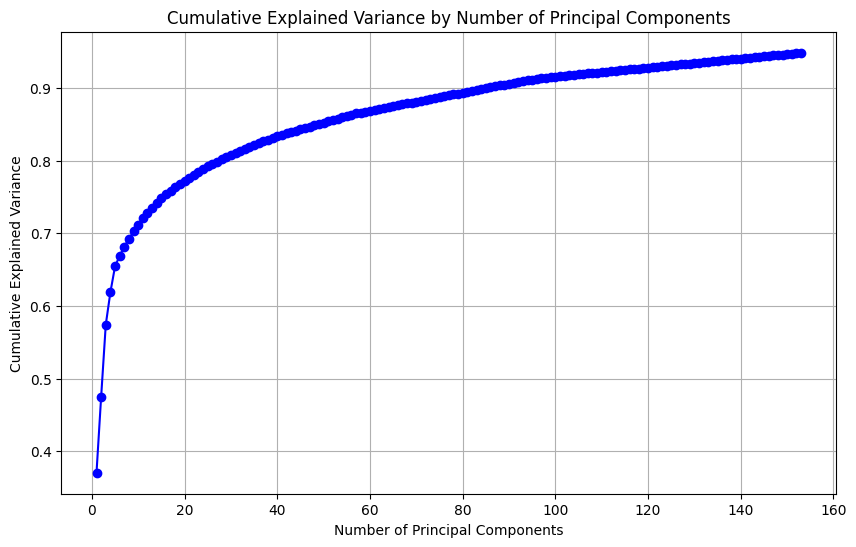

In [16]:
# Use PCA to reduce the feature space to improve the models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# Use a loop to test how many Prnicipal components to keep with the model
principal_components_tr = []
principal_components_te = []
for num_comp in range(1, 154):
    pca = PCA(n_components=num_comp)
    principal_components_tr.append(pca.fit_transform(X_train))
    principal_components_te.append(pca.transform(X_test))

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 154), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

## Explained Var Ratio

The cumulative explained variance can be seen above. While it looks like at around 90 components that 90% of the variability is explained in the data, which is a good benchmark to use for the number of components to include in the models, I will nonetheless loop through all of the components, building each model and seeing which models produce the best results, effectively tailoring the number of components to each model.

## Using PCA on the Linear Regressor

In [17]:
# Test how PCA compares with Forward Selection test on all Principal Components on the data and find the best params
best_mae_tr_lr_w_pca = np.inf
best_mae_te_lr_w_pca = np.inf
best_number_of_components_tr = 0
best_number_of_components_te = 0
best_r2 = -np.inf
best_r2_feat = 0

for feature_idx in range(len(principal_components_tr)):
    X_train_pca_const = sm.add_constant(principal_components_tr[feature_idx])
    X_test_pca_const = sm.add_constant(principal_components_te[feature_idx])
    linear_model_pca = sm.OLS(y_train, X_train_pca_const).fit()
    y_pred_tr = linear_model_pca.predict(X_train_pca_const)
    y_pred_te = linear_model_pca.predict(X_test_pca_const)

    mae_tr_lr_w_pca = mean_absolute_error(y_train, y_pred_tr)
    mae_te_lr_w_pca = mean_absolute_error(y_test, y_pred_te)

    if linear_model_pca.rsquared > best_r2:
        best_r2 = linear_model_pca.rsquared
        best_r2_feat = feature_idx

    if mae_tr_lr_w_pca < best_mae_tr_lr_w_pca:
        best_mae_tr_lr_w_pca = mae_tr_lr_w_pca
        best_number_of_components_tr = feature_idx

    if mae_te_lr_w_pca < best_mae_te_lr_w_pca:
        best_mae_te_lr_w_pca = mae_te_lr_w_pca
        best_number_of_components_te = feature_idx

print(f'min training MAE is {best_mae_tr_lr_w_pca:.4f} at {best_number_of_components_tr} number of components')
print(f'min testing MAE is {best_mae_te_lr_w_pca:.4f} at {best_number_of_components_tr} number of components')
print(f'max r2 is {best_r2:.4f} at {best_r2_feat:.4f} number of components')

min training MAE is 29290.20884874445 at 150 number of components
min testing MAE is 34991.4834222554 at 150 number of components
max r2 is 0.2563848110407635 at 152 number of components


## Construct base SVM, RF, and GB Supervised Models
Here I create base models for SVM, RF, and Gradient Boosting to compare the results of these models using the original feature space to these models using the PCA feature space

### Support Vector Machine

In [18]:
# Use a Support Vector Machine Classifier to see if there is better performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and fit the SVM model
svm_model = SVR(kernel='poly')
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Calculate mean absolute error
mae_svm = mean_absolute_error(y_test, y_pred_svm)
print(f'Mean Absolute Error is: {mae_svm}')

# Calculate R^2
r2_svm = r2_score(y_test, y_pred_svm)
print(f'SVM R² Score: {r2_svm:.4f}')

Mean Absolute Error is: 33568.391104084956
SVM R² Score: -0.0426


### Random Forest

In [19]:
# Random Forest Predictor
# Initialize the Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=500, random_state=42)

# Fit the model on training data
random_forest.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = random_forest.predict(X_test)

# Calculate Mean Absolute Error
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Random Forest Mean Absolute Error: {mae_rf}')

# Calculate R^2
r2_rf = r2_score(y_test, y_pred_rf)
print(f'RF R² Score: {r2_rf:.4f}')

Random Forest Mean Absolute Error: 40503.92291563738
RF R² Score: -0.3819


### Gradient Boosting

In [20]:
# Gradient Boost Regressor
# Initialize the Gradient Boosting Regressor
gb_rg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.00001, max_depth=7, random_state=42)

# Fit the model on training data
gb_rg.fit(X_train, y_train)

# Predict on the test data
y_pred_gb = gb_rg.predict(X_test)

# Evaluate the model
mae_gbr = mean_absolute_error(y_test, y_pred_gb)
r2_gbr = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting Regressor Mean Absolute Error: {mae_gbr:.4f}')
print(f'Gradient Boosting Regressor R² Score: {r2_gbr:.4f}')

Gradient Boosting Regressor Mean Absolute Error: 35089.7115
Gradient Boosting Regressor R² Score: 0.0003


## Using PCA feat reduction on the SVM, RF, and GB models
Here I use the PCA model/features I created, but will implement them into the SVM, Random Forest, and Gradient Booting methods to compare them with the base models.

In [21]:
## Test each model on the PCA features and determine best MAE
scaler = StandardScaler()
models = [SVR(kernel='poly'), RandomForestRegressor(n_estimators=500, random_state=42), GradientBoostingRegressor(n_estimators=1000, learning_rate=0.00001, max_depth=7, random_state=42)]
best_mae_svr_w_pca = np.inf
best_mae_rf_w_pca = np.inf
best_mae_gb_w_pca = np.inf
best_number_of_components_svr = 0
best_number_of_components_rf = 0
best_number_of_components_gb = 0
best_r2_svr = -np.inf
best_r2_rf = -np.inf
best_r2_gb = -np.inf
best_r2_feat_svr = -np.inf
best_r2_feat_rf = -np.inf
best_r2_feat_gb = -np.inf
for feature_idx in range(len(principal_components_tr)):
    print(f'Analyzing results at {feature_idx+1} components')
    for i, model in enumerate(models):
        model.fit(principal_components_tr[feature_idx], y_train)
        y_pred = model.predict(principal_components_te[feature_idx])
        current_r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        if i == 0:
            if mae < best_mae_svr_w_pca:
                best_mae_svr_w_pca = mae
                best_number_of_components_svr = feature_idx
            if current_r2 > best_r2_svr:
               best_r2_svr = current_r2
               best_r2_feat_svr = feature_idx
        elif i == 1:
            if mae < best_mae_rf_w_pca:
                best_mae_rf_w_pca = mae
                best_number_of_components_rf = feature_idx
            if current_r2 > best_r2_rf:
               best_r2_rf = current_r2
               best_r2_feat_rf = feature_idx
        else:
            if mae < best_mae_gb_w_pca:
                best_mae_gb_w_pca = mae
                best_number_of_components_gb = feature_idx
            if current_r2 > best_r2_gb:
                best_r2_gb = current_r2
                best_r2_feat_gb = feature_idx
print(f'min MAE for SVM is {best_mae_svr_w_pca} at {best_number_of_components_svr} number of components. Best r2 is {best_r2_svr} at {best_r2_feat_svr} number of components')
print(f'min MAE for RF is {best_mae_rf_w_pca} at {best_number_of_components_rf} number of components. Best r2 is {best_r2_rf} at {best_r2_feat_rf} number of components')
print(f'min MAE for GB is {best_mae_gb_w_pca} at {best_number_of_components_gb} number of components. Best r2 is {best_r2_gb} at {best_r2_feat_gb} number of components')


Analyzing results at 1 components
Analyzing results at 2 components
Analyzing results at 3 components
Analyzing results at 4 components
Analyzing results at 5 components
Analyzing results at 6 components
Analyzing results at 7 components
Analyzing results at 8 components
Analyzing results at 9 components
Analyzing results at 10 components
Analyzing results at 11 components
Analyzing results at 12 components
Analyzing results at 13 components
Analyzing results at 14 components
Analyzing results at 15 components
Analyzing results at 16 components
Analyzing results at 17 components
Analyzing results at 18 components
Analyzing results at 19 components
Analyzing results at 20 components
Analyzing results at 21 components
Analyzing results at 22 components
Analyzing results at 23 components
Analyzing results at 24 components
Analyzing results at 25 components
Analyzing results at 26 components
Analyzing results at 27 components
Analyzing results at 28 components
Analyzing results at 29 compo

# Multilayer Perceptron

Below I create a simple MLP. The architecture contains 3 dense layers with decreasing number of neurons for each layer. Every perceptron uses a relu activation function. Finally, the output contains one perceptron with no activation function. The omission of the activation function is due to the nature of the problem being a regression problem which typically requires the raw output score (e.g. predicted salary in thousands of dollars). We run the model over 1000 epochs with a batch size of 32 to thoroughly train the model.  

In [30]:
# Build the MLP model
inputs = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.1, batch_size=32)

# Evaluate
mlp_loss, mlp_mae = model.evaluate(X_test, y_test)
print(f"MLP MAE: {mlp_mae}")

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 18678013952.0000 - mae: 127742.1172 - val_loss: 17785892864.0000 - val_mae: 125553.6641
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 17838006272.0000 - mae: 126008.8125 - val_loss: 17784977408.0000 - val_mae: 125549.9531
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19175520256.0000 - mae: 128940.1172 - val_loss: 17783019520.0000 - val_mae: 125541.8672
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18983174144.0000 - mae: 129373.0469 - val_loss: 17779087360.0000 - val_mae: 125525.4844
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18274971648.0000 - mae: 127212.2031 - val_loss: 17771749376.0000 - val_mae: 125494.8203
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17480673280.0000 - mae: 125134.3281 - val_loss: 17758410752.0000 - val_mae: 125438.9531
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18732171264.0000 - mae: 128122.2969 - val_loss: 17

# Results
Below is a bar chart that compares the mean absolute error of all the models. In addition, a bell curve plotting the residuals from the best model is displayed.

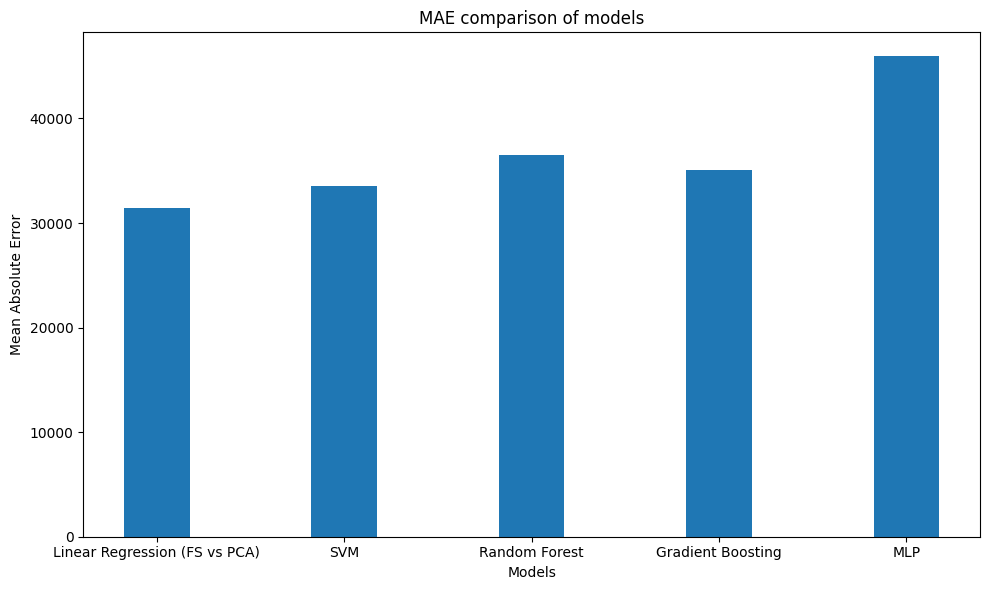

In [37]:
# Model names
models = ['Linear Regression (FS vs PCA)', 'SVM', 'Random Forest', 'Gradient Boosting', 'MLP']

# MAE values
mae_with_pca = [best_mae_lrfs, best_mae_svr_w_pca, best_mae_rf_w_pca, best_mae_gb_w_pca, mlp_mae]

# Bar positions
bar_width = 0.35  # Width of the bars
index = np.arange(len(models))  # Index for each group (each model)

fig, ax = plt.subplots(figsize=(10,6))
bar = ax.bar(index + bar_width, mae_with_pca, bar_width)

ax.set_xlabel('Models')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('MAE comparison of models')
ax.set_xticks(index + bar_width)  # Centering the ticks
ax.set_xticklabels(models)

plt.tight_layout()
plt.show()

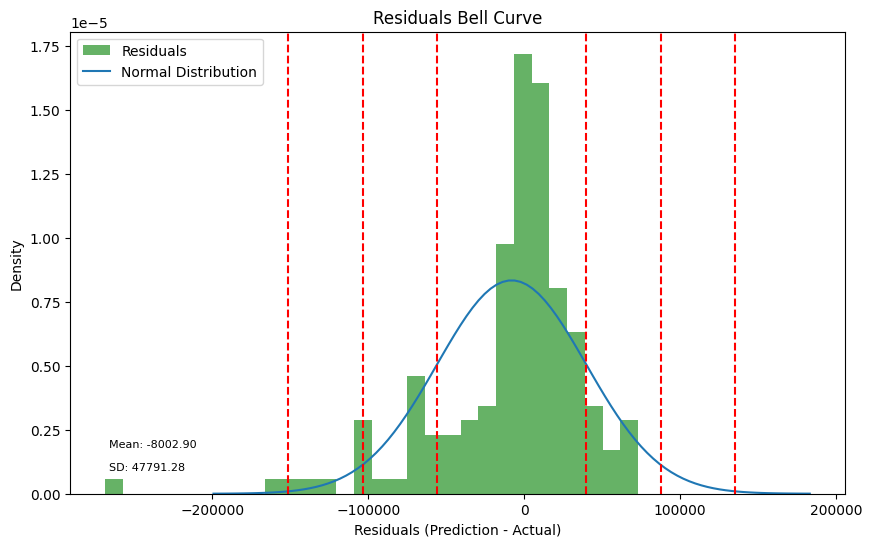

In [38]:
# Re-create the best model, extract the residuals, and plot the bell curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

best_model = sm.OLS(y_train, X_train[initial_features]).fit()
y_pred = best_model.predict(X_test[initial_features])

pred_test_vals = [(y_pred_i, y_test_i) for y_pred_i, y_test_i in zip(y_pred, y_test)]

# residuals (predictions - actual values)
residuals = np.array([pred - actual for pred, actual in pred_test_vals])

# Calculate mean and standard deviation
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

# Generate x values for the bell curve
x_values = np.linspace(mean_residuals - 4*std_residuals, mean_residuals + 4*std_residuals, 100)

plt.figure(figsize=(10,6))

# Plot the histogram
hist = plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g', label="Residuals")

# Plot the bell curve (normal distribution)
curve, = plt.plot(x_values, norm.pdf(x_values, mean_residuals, std_residuals), label="Normal Distribution")

# Plot vertical lines for standard deviations
for i in range(1, 4):
    line1 = plt.axvline(mean_residuals + i*std_residuals, color='r', linestyle='--', label=f'+{i} SD')
    line2 = plt.axvline(mean_residuals - i*std_residuals, color='r', linestyle='--', label=f'-{i} SD')

plt.annotate(f'Mean: {mean_residuals:.2f}', xy=(0.05, 0.1), xycoords='axes fraction', fontsize=8, color='black')
plt.annotate(f'SD: {std_residuals:.2f}', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=8, color='black')

# customize which parts of the plot appear in the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Filter out unwanted legend labels
desired_handles = [handles[0], handles[1]]  # Only show 'Normal Distribution'
desired_labels = [labels[0], labels[1]]

plt.legend(desired_handles, desired_labels)  # Create the legend with filtered labels

# Show plot
plt.title("Residuals Bell Curve")
plt.xlabel("Residuals (Prediction - Actual)")
plt.ylabel("Density")
plt.show()

# Discussion/Conclusion

Based on the bar chart, the model that performed the best was still the linear regressor with forward selection to reduce the features. This could be because forward selection directly selects the most relevant features based on the model's performance, rather than based on variance as in PCA. Forward selection tailors the feature selection process to the model's outcome, which has a direct impact on how well it performs. PCA is great for reducing dimensionality, but it doesn't always keep the features that  result in the best predictions of the target, which may be why it underperformed compared to PCA.

SVM and Gradient Boosting saw no effect between keeping all of the features and reducing the features using PCA. This demonstrates that these models are capable of producing consistent results in spite of how large a feature space may be. Therefore, PCA did not provide additional value in improving their performance.

The model that saw the largest improvement using PCA to reduce the feature space was random forest. This is an intially suprising result, considering that random forest are generally capable of handling a larger feature space. Nonetheless, the feature space could have contained highly correlated features, which impacts how well random forests are able to generalize to the test data. Since PCA not only reduces the feature space, but also decorrelates the data, the random forrest model saw substantial improvement. Therfore, when the random forrest model is presented with highly correlated data, it could still substantially benefit from the PCA feature reduction technique.

The MLP actually performed the worse out of all the models. This is perhaps because the network is fairly simple. Perhaps a deeper model with batch normalization and dropout would perform better. In addition, though the network was trained over 1000 epochs, perhaps more epochs and longer training time would produce better results.


Overall, the supervised models producecd moderate predictions of salary information so that they could be used in practical applications. For example, given that some companies do not give a salary range for their job postings, one of these models could be used to predict the salary based on the job title, location, and company score (which could be looked up online). Nonetheless, the prediction has a significant likelihood of having a large error, rendering the result of the prediction to be untrustworthy. Looking at the bell curve for the Linear Regressor with Forward Selection, the model was off on average by $\$$8000, which is not bad on the surface, however, the data is spread fairly wide with a standard deviation of $\$$47,791. This means that approximately 70% of the predictions are within a $\$$47,791 tolerance. That being said, there are some significant outliers affecting the bell curve plot in the model. One prediction was about $\$$250,000 off of the actual value. This has a significant impact on the mean and standard deviation.

A way to improve the predictions would be to work on tuning the features more for each model, even doing more feature engineering past PCA. One of the best ways to improve these models is to find more important features. For example, one highly correlated feature with salary is years of experience. If the expected 'years of experience' data could be extracted from the job postings, perhaps this would make a better feature than 'job title' which is a categorical feature. More numerical features could be helpful in predicting the salaries rather than the categorical variables that I was able to attain in the dataset.

Another takeaway from this project is that while neural networks are all the buzz right now, traditional machine learning models can perform just as well if not better than neural networks for certain tasks. In this project, the most complicated model (the MLP) presented the worst results whereas the simplest model (the linear regressor) was the highest performing model. The principal of Occam's Razor also applies here, which states that when multiple models perform similarly, the simiplest model should be selected. In this case, the linear regressor should be chosen to predict the software engineering salaries.

In conclusion, while the linear regressor model with feature selection performed the best over the rest of the models, it still contained a significant amount of error. While this could introduce a lack of trust in the model's predictions in a real-world scenario, the prediction could still be used as a practical baseline, since the user understands there may be siginifanct error in the prediction.